In [59]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [60]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import AutoTokenizer
import json
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader

In [2]:
configdict= {
    "gpt-1M":{
        "batch_size": 64,
        "block_size": 256,
        "max_pos_n_embed": 2048,
        "lr": 2e-3,
        "n_layer": 8,
        "n_head": 16,
        "n_embed": 64,
        "dropout": 0.2,
        "epochs": 1,
        "eval_interval": 200,
        "eval_steps": 50,
        "n": 1200000,
        "k": 7999,
        "vocab_size": 8000,
    },
    "gpt-15M":{
        "batch_size": 64,
        "block_size": 256,
        "max_pos_n_embed": 2048,
        "lr": 2e-3,
        "n_layer": 8,
        "n_head": 16,
        "n_embed": 320,
        "dropout": 0.2,
        "epochs": 1,
        "eval_interval": 200,
        "eval_steps": 50,
        "n": 1200000,
        "k": 7999,
        "vocab_size": 8000,
    },
     "tokenizer":{
        "name": "EleutherAI/gpt-neo-125M",
    },
    "data":{
        "name": "roneneldan/TinyStories",
    },
}

class Config:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            if isinstance(value, dict):
                setattr(self, key, Config(value))
            else:
                setattr(self, key, value)

    def __getitem__(self, key):
        return self.__dict__[key]

config = Config(configdict)

In [54]:
class Tokenizer:
  def __init__(self, config, k=None, file_path=None, device="cpu"):
    self.k = k
    self.file_path = file_path
    self.device = device
    self.tokenizer = AutoTokenizer.from_pretrained(config.name)
    self.tokenizer.pad_token = self.tokenizer.eos_token
    self.vocab_size = self.tokenizer.vocab_size if not self.k else self.k
    self.initialize()

  def get_config(self):
    config = {
        "initl_vocab_size": self.tokenizer.vocab_size,
        "final_vocab_size": self.vocab_size,
        "vocab_size": self.vocab_size,
        "total_tokens": self.total_tokens,
        "total_tokens_used": self.tokens_used if self.k else self.total_tokens,
        "total_unsed_tokens": self.total_tokens - self.tokens_used if self.k else 0
    }
    return config

  def initialize(self):
    with open(self.file_path, 'r') as file:
      tokens_counts = json.load(file)

    self.total_tokens = sum(tokens_counts.values()) # Already sorted

    if self.k:
      self.tokens_used = sum([i for i in tokens_counts.values()][:self.k])
      self.top_k_tokens = [i for i in tokens_counts.keys()][:self.k]# We will only use top k tokens, others will be ignored
      self.top_k_tokens.append("50256")
      self.vocab_size +=1
      self.top_k_tokens_dict =  {token: index for index, token in enumerate(self.top_k_tokens)}
      self.reversed_top_k_tokens_dict = {value: int(key) for key, value in self.top_k_tokens_dict.items()}


  def encoder(self, input, padding=False, max_length=256, truncation=False):
    tokens = self.tokenizer(input , return_tensors='pt', padding=padding, max_length=max_length, truncation=truncation)['input_ids'].to(self.device)

    if self.k:
      tokens = torch.tensor([self.top_k_tokens_dict.get(str(token.item()), self.top_k_tokens_dict["50256"]) for token in tokens.view(-1)], device=self.device).view(tokens.shape)

    return tokens

  def decoder(self, tokens):
    if self.k:
      tokens = torch.tensor([[self.reversed_top_k_tokens_dict[token.item()] for token in row] for row in tokens], device=tokens.device)

    output = [self.tokenizer.decode(x, skip_special_tokens=True) for x in tokens]

    return output

In [56]:
class Head(nn.Module):
  def __init__(self, config, head_size):
    super().__init__()
    self.key = nn.Linear(config.n_embed, head_size, bias=False)
    self.query = nn.Linear(config.n_embed, head_size, bias=False)
    self.value = nn.Linear(config.n_embed, head_size, bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(config.block_size, config.block_size)))  # (T, T)
    self.dropout = nn.Dropout(config.dropout)

  def forward(self, x):
    B, T, C = x.shape
    k = self.key(x) # (B, T, C)
    q = self.query(x) # (B, T, C)
    wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5 # (B, T, C) X (B, C, T) --> (B, T, T)
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
    wei = F.softmax(wei, dim=-1)
    wei = self.dropout(wei)
    v = self.value(x)  # (B,T,C)
    out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
    return out


class MultiHeadAttention(nn.Module):
  def __init__(self, config, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(config, head_size) for _ in range(config.n_head)])
    self.proj  = nn.Linear(head_size * config.n_head, config.n_embed)
    self.dropout = nn.Dropout(config.dropout)

  def forward(self,x):
    out = torch.concat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out


class FeedForward(nn.Module):
  def __init__(self, config):
   super().__init__()
   self.layers = nn.Sequential(
        nn.Linear(config.n_embed, 4 * config.n_embed),
        nn.GELU(),
        nn.Linear(4 * config.n_embed, config.n_embed),
        nn.Dropout(config.dropout),
    )

  def forward(self,x):
    return self.layers(x)


class Block(nn.Module):
  def __init__(self, config):
    super().__init__()
    head_size = config.n_embed // config.n_head
    self.sa_heads = MultiHeadAttention(config, head_size)
    self.ffwd = FeedForward(config)
    self.ln1 = nn.LayerNorm(config.n_embed)
    self.ln2 = nn.LayerNorm(config.n_embed)

  def forward(self, x):
    x = x + self.sa_heads(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x


class GPT2(nn.Module):
  def __init__(self, config, device='cpu'):
    super().__init__()
    self.device = device
    self.block_size = config.block_size
    self.embedings = nn.Embedding(config.vocab_size, config.n_embed)
    self.position_embedings = nn.Embedding(config.max_pos_n_embed, config.n_embed)
    self.dropout = nn.Dropout(config.dropout)
    self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
    self.ln_final = nn.LayerNorm(config.n_embed)
    self.lm_head = nn.Linear(config.n_embed, config.vocab_size)

  def get_parameters(self):
    return sum(p.numel() for p in self.parameters())

  def save(self, path):
    torch.save(self.state_dict(), path)

  def forward(self, idx, targets=None):
    B, T = idx.shape
    token_embed = self.embedings(idx) # (B, T, C)
    position_embed = self.position_embedings(torch.arange(T,  device=self.device)) # (T, C)
    x = token_embed + position_embed # (B, T, C)
    x = self.dropout(x) # (B, T, C)
    x = self.blocks(x) # (B, T, C)
    x = self.ln_final(x) # (B, T, C)
    logits = self.lm_head(x)  # (B, T, vocab_size)

    if targets is None:
      loss = None
    else:
      logits = logits[..., :-1, :].contiguous()
      loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets[..., 1:].contiguous().view(-1), ignore_index=50256)
    return logits, loss

  def generate(self, idx, max_tokens, temperature=1.0, top_k=None):
    # idx is (B, T)
    for _ in range(max_tokens):
      idx_cond = idx[:, -self.block_size:]
      logits, _ = self(idx_cond) # (B, T, C)
      logits = logits[:, -1, :]  / temperature # (B, C)
      if top_k is not None:
        v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
        logits[logits < v[:, [-1]]] = -float('Inf')
      probs = F.softmax(logits, dim=-1) # Softmax Independently for C dim
      idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
      idx = torch.concat((idx, idx_next), dim=1) # (B, T+1)
    return idx

In [69]:
def load_data(config, batch_size, n, device='cpu'):
    dataset = load_dataset(config.name)
    train_data = DataLoader(dataset["train"][:n]["text"], batch_size=batch_size, shuffle=True, pin_memory=True, pin_memory_device=device)
    val_data = DataLoader(dataset["validation"][:n]["text"], batch_size=batch_size, shuffle=True, pin_memory=True, pin_memory_device=device)

    return train_data, val_data

@torch.no_grad()
def estimate_loss(model, train_data, val_data, encoder, eval_steps=50):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_steps)
        for k in range(eval_steps):
            data = train_data if split == 'train' else val_data
            tokens = encoder(next(iter(data))[0], max_length=model.block_size, padding="max_length", truncation=True)
            _, loss = model(tokens, tokens)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


def plot_losses(losses):
    train_losses = [o['train'] for o in losses if o.get('train') is not None]
    valid_losses = [o['valid'] for o in losses if o.get('valid') is not None]
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()
    plt.show()

In [64]:
class Trainer:
  def __init__(self, config, model, optimizer, train_data, val_data, encoder):
    self.config = config
    self.model = model
    self.optimizer = optimizer
    self.train_data = train_data
    self.val_data = val_data
    self.encoder = encoder

  def train(self, epochs, eval_interval=200, eval_steps=50):
    max_steps = epochs * round(self.config.n / self.config.batch_size)
    steps = 0
    tracked_losses = []

    for epoch in range(epochs):
      print(f"Starting Epoch: {epoch + 1} {'-' * 100}")
      for batch in self.train_data:
        if steps % eval_interval == 0 or steps == max_steps-1:
          losses = estimate_loss(self.model, self.train_data, self.val_data, self.encoder, eval_steps)
          tracked_losses.append(losses)
          print(f"Epoch: {epoch + 1}/{epochs} | Step: {steps}/{max_steps} | Train loss: {losses['train']:.4f} | Val loss: {losses['val']:.4f}")

        tokens = self.encoder(batch, max_length=self.config.block_size, padding="max_length", truncation=True)
        _, loss = self.model(tokens, tokens)
        self.optimizer.zero_grad(set_to_none=True)
        loss.backward()
        self.optimizer.step()
        steps += 1

    return tracked_losses

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Starting Epoch: 1 ----------------------------------------------------------------------------------------------------
Epoch: 1/1 | Step: 0/18750 | Train loss: 9.0884 | Val loss: 9.0914
{'initl_vocab_size': 50257, 'final_vocab_size': 8000, 'vocab_size': 8000, 'total_tokens': 476616445, 'total_tokens_used': 475526033, 'total_unsed_tokens': 1090412}


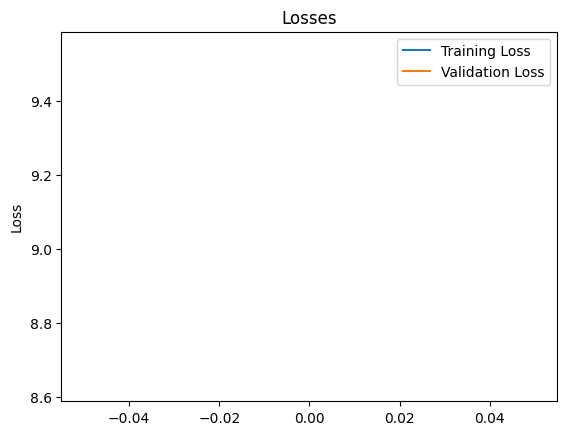

In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name= "gpt-1M"
model_config = config[model_name]

train_data, val_data = load_data(config.data, model_config.batch_size, 64, device=device)
tokenizer = Tokenizer(config.tokenizer, k=model_config.k, file_path="tokens.json", device=device)

model = GPT2(model_config, device=device)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=model_config.lr)

trainer = Trainer(model_config, model, optim, train_data, val_data, tokenizer.encoder)
tracked_losses = trainer.train(epochs=1, eval_interval=200, eval_steps=50)
model.save("model-1M.pth")

print(tokenizer.get_config())
plot_losses(tracked_losses)